In [45]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.__version__

'2.6.0'

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                              weights="imagenet")

87924736/87910968 [==============================] - 6s 0us/step


In [5]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
len(base_model.layers)

311

In [7]:
# names = ["mixed3","mixed5","mixed8","mixed9"]
names = ["mixed3","mixed5"]

In [10]:
layers = [base_model.get_layer(name).output for name in names]
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [9]:
from tensorflow.keras import Model

deep_dream_model = Model(inputs=base_model.input,
                         outputs=layers)

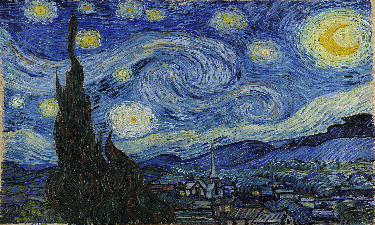

In [26]:
from tensorflow.keras.preprocessing.image import load_img

image = load_img("Images/StaryNight.jpg",target_size=(225,375))
image

In [27]:
image.mode,image.size,type(image)

('RGB', (375, 225), PIL.Image.Image)

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array

image = img_to_array(image)

In [29]:
image.shape,image.size,type(image)

((225, 375, 3), 253125, numpy.ndarray)

In [30]:
image.min(),image.max()

(0.0, 255.0)

In [31]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

image = preprocess_input(image)

In [32]:
image.min(),image.max()

(-1.0, 1.0)

In [34]:
image_batch = tf.expand_dims(image,axis=0)

In [39]:
activations = deep_dream_model.predict(image_batch)
len(activations)

2

In [60]:
def calculate_loss(image,network):
    """
    Calculate the loss of the outputs
    """
    image_batch = tf.expand_dims(image,axis=0)
    activations = network(image_batch)
    losses = []
    for act in activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [53]:
calculate_loss(image,deep_dream_model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6168045>

In [61]:
@tf.function
def deep_dream(network,image,learning_rate):
    """
    Calculate the gradient ascent
    """
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calculate_loss(image,network)
    gradients = tape.gradient(loss,image)  # Derivative
    gradients /= tf.math.reduce_std(gradients)
    image = image + gradients*learning_rate
    image = tf.clip_by_value(image,-1,1)
    return loss,image

In [69]:
def inverse_transform(image):
    image = 255 * (image+1)/2
    return tf.cast(image,tf.uint8)

In [70]:
def run_deep_dream(network,image,epochs,learning_rate):
    for epoch in range(epochs):
        loss,image = deep_dream(network,image,learning_rate)
        if epoch%200==0:
            plt.figure(figsize=(12,12))
            plt.imshow(inverse_transform(image))
            plt.show()
            print(f"Epoch: {epoch}, loss: {loss}")

In [71]:
image.shape,type(image)

((225, 375, 3), numpy.ndarray)

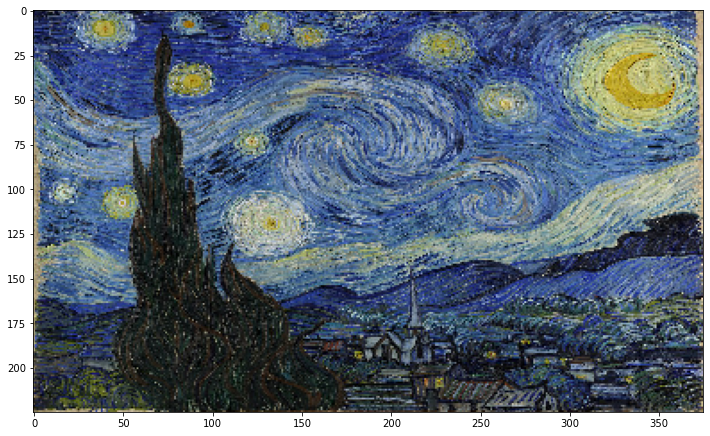

Epoch: 0, loss: 0.6168044805526733


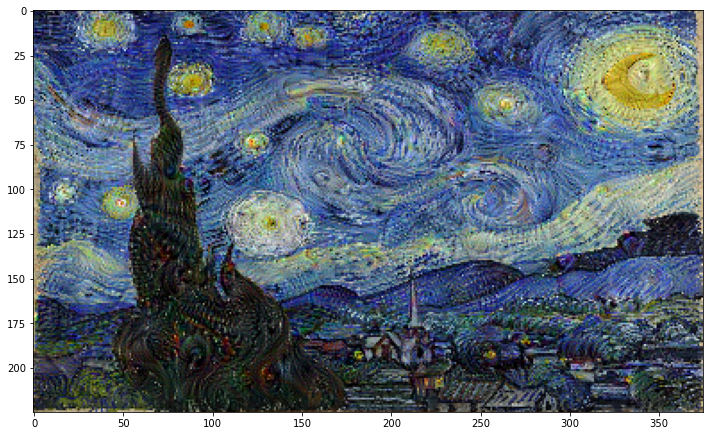

Epoch: 200, loss: 1.7168349027633667


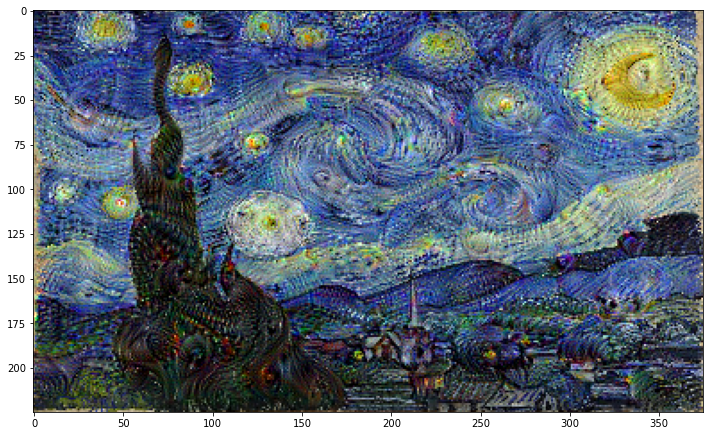

Epoch: 400, loss: 2.0433595180511475


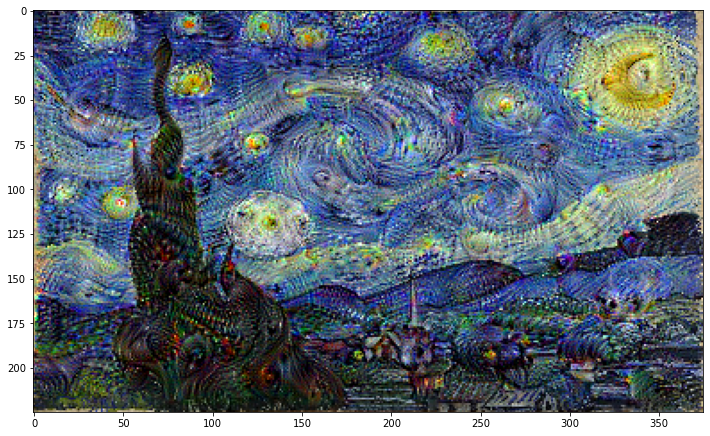

Epoch: 600, loss: 2.2439675331115723


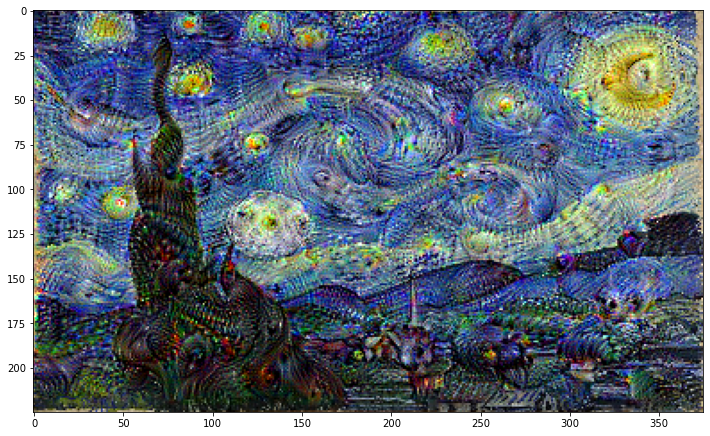

Epoch: 800, loss: 2.3950424194335938


In [73]:
run_deep_dream(deep_dream_model,image,1000,learning_rate=0.001)